In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
from constant import org_cols, wsr_cols, geo_cols, semigeo_cols
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training
path = "SL_SC_1/"

# Load Files

In [ ]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_SL_SC_path, dtype=dtype).sample(frac=0.05, random_state=1)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [ ]:
len(windmill)

In [ ]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [ ]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [ ]:
df = features.parallelize_extract(df)

In [ ]:
df,ply_models_rn,_ = features.extract_quantiles(df, "hws_uv_rn")
df,ply_models_wsr,_ = features.extract_quantiles(df, "hws_uv_wsr")

In [ ]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [ ]:
cols = [x for x in df.columns if x not in cols_filter]
df[cols] = tools.normalize_maxmin(df[cols])
df['VAERDI'] = df['VAERDI'] / df['max_VAERDI'] 

In [ ]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])

In [ ]:
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)

In [ ]:
len(df_train)

In [ ]:
df_train.to_parquet(constant.SL_SC_TRAIN_path, index=False)
df_evl.to_parquet(constant.SL_SC_EVL_path, index=False)

# Neural Network Train

In [2]:
df_train = pd.read_parquet(constant.SL_SC_TRAIN_path)

In [4]:
target = ["VAERDI"]
n_groups=10
lr=0.001
num_epochs=50
hidden_size = 1000
output_size = 1

## Original Features


In [6]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)

### Timeserise K-Fold-Validation

In [7]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=org_cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.035206422209739685 test loss: 0.030442014336586
Epoch 10 train loss: 0.02284429594874382 test loss: 0.021657342091202736
Epoch 20 train loss: 0.02212795615196228 test loss: 0.021609395742416382
Epoch 30 train loss: 0.02137935720384121 test loss: 0.02170778624713421
Epoch 40 train loss: 0.020612604916095734 test loss: 0.02204958349466324
Epoch 49 train loss: 0.019880399107933044 test loss: 0.02252037078142166
Epoch 0 train loss: 0.021390343084931374 test loss: 0.008259552530944347
Epoch 10 train loss: 0.02092147246003151 test loss: 0.008346066810190678
Epoch 20 train loss: 0.020485905930399895 test loss: 0.008243054151535034
Epoch 30 train loss: 0.019965728744864464 test loss: 0.008104564622044563
Epoch 40 train loss: 0.019372930750250816 test loss: 0.008046472445130348
Epoch 49 train loss: 0.018711289390921593 test loss: 0.007830172777175903
Epoch 0 train loss: 0.01833275333046913 test loss: 0.010436723940074444
Epoch 10 train loss: 0.01855243742465973 test loss: 

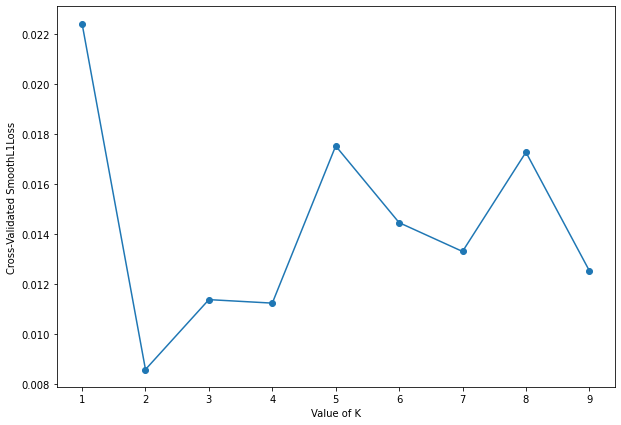

<Figure size 432x288 with 0 Axes>

In [8]:
myplot.k_fold_validation(n_groups, k_scores, save_name=path+"original_k_fold.png")

### Train model

In [9]:
x_train, y_train = df_train[org_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [10]:
model_original, train_hist_original, _ = train_model(
                                            model_original, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            save_name=path+"original_model.pth")

Epoch 0 train loss: 0.009913894347846508
Epoch 10 train loss: 0.010091529227793217
Epoch 20 train loss: 0.009828108362853527
Epoch 30 train loss: 0.009747346863150597
Epoch 40 train loss: 0.009713491424918175


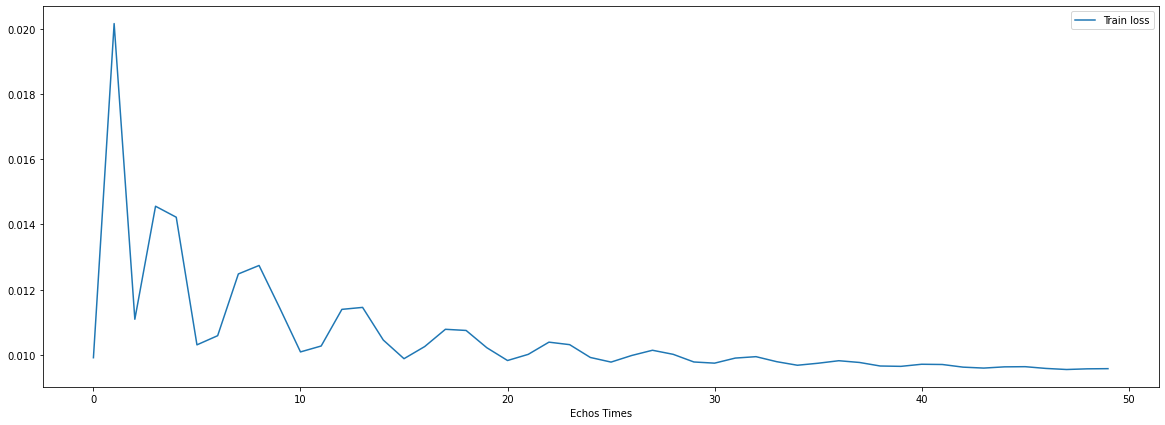

In [11]:
myplot.model_loss({"Train loss":train_hist_original}, save_name=path+"original_loss.png")

## Windshear Features

In [14]:
model_wsr = MLP_Regression(
  input_size=47,
  hidden_size=hidden_size
)

In [15]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=wsr_cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.03400646522641182 test loss: 0.033306416124105453
Epoch 10 train loss: 0.01458582654595375 test loss: 0.01586919277906418
Epoch 20 train loss: 0.012745332904160023 test loss: 0.013809765689074993
Epoch 30 train loss: 0.01215619407594204 test loss: 0.013174348510801792
Epoch 40 train loss: 0.011879279278218746 test loss: 0.013468598015606403
Epoch 49 train loss: 0.011660500429570675 test loss: 0.013260170817375183
Epoch 0 train loss: 0.012438755482435226 test loss: 0.00628172280266881
Epoch 10 train loss: 0.014093647710978985 test loss: 0.008010282181203365
Epoch 20 train loss: 0.01251513697206974 test loss: 0.006600022781640291
Epoch 30 train loss: 0.012142051011323929 test loss: 0.006196159869432449
Epoch 40 train loss: 0.012071930803358555 test loss: 0.006151965819299221
Epoch 49 train loss: 0.01200234517455101 test loss: 0.006147320382297039
Epoch 0 train loss: 0.011772839352488518 test loss: 0.007917185313999653
Epoch 10 train loss: 0.013531429693102837 test l

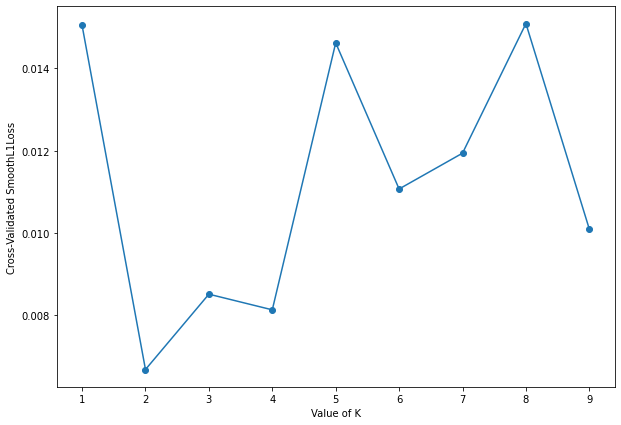

<Figure size 432x288 with 0 Axes>

In [16]:
myplot.k_fold_validation(n_groups, k_scores, save_name=path+"wsr_k_fold.png")

### Train model

In [17]:
x_train, y_train = df_train[wsr_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [18]:
model_wsr, train_hist_wsr, _ = train_model(model_wsr, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            save_name=path+"wsr_model.pth")

Epoch 0 train loss: 0.010204155929386616
Epoch 10 train loss: 0.01144920103251934
Epoch 20 train loss: 0.010357585735619068
Epoch 30 train loss: 0.01011818740516901
Epoch 40 train loss: 0.010084062814712524


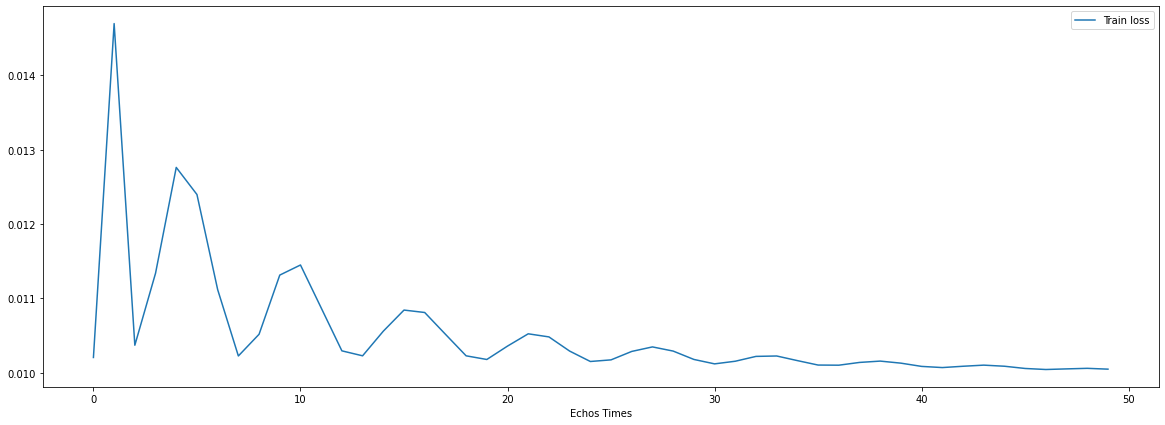

In [19]:
myplot.model_loss({"Train loss":train_hist_wsr}, save_name=path+"wsr_loss.png")

## Geo Features

In [21]:
model_geo = MLP_Regression(
  input_size=49,
  hidden_size=hidden_size
)

In [22]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=geo_cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.03865179046988487 test loss: 0.033945824950933456
Epoch 10 train loss: 0.013004968874156475 test loss: 0.013059215620160103
Epoch 20 train loss: 0.009599716402590275 test loss: 0.01017629262059927
Epoch 30 train loss: 0.008844634518027306 test loss: 0.008910419419407845
Epoch 40 train loss: 0.008685136213898659 test loss: 0.008601116947829723
Epoch 49 train loss: 0.008514316752552986 test loss: 0.008559353649616241
Epoch 0 train loss: 0.008930790238082409 test loss: 0.004713385831564665
Epoch 10 train loss: 0.01053579617291689 test loss: 0.006024085450917482
Epoch 20 train loss: 0.00883475597947836 test loss: 0.004674434661865234
Epoch 30 train loss: 0.008912595920264721 test loss: 0.004697542637586594
Epoch 40 train loss: 0.008822701871395111 test loss: 0.004643886350095272
Epoch 49 train loss: 0.008714280091226101 test loss: 0.004589923191815615
Epoch 0 train loss: 0.008553261868655682 test loss: 0.006145941559225321
Epoch 10 train loss: 0.010020743124186993 tes

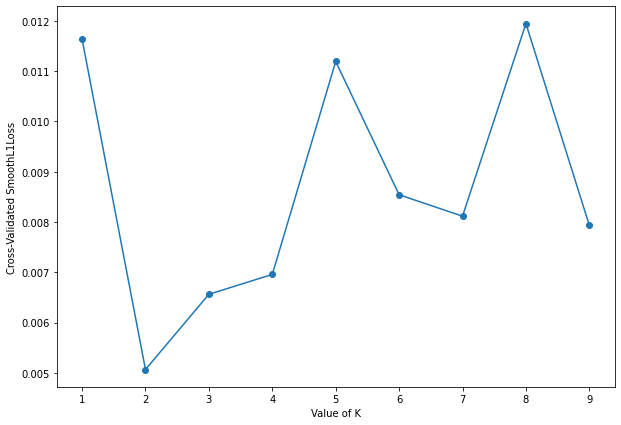

<Figure size 432x288 with 0 Axes>

In [23]:
myplot.k_fold_validation(n_groups, k_scores, save_name=path+"geo_k_fold.png")

### Train model

In [24]:
x_train, y_train = df_train[geo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [25]:
model_geo, train_hist_geo, _ = train_model(model_geo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            save_name=path+"geo_model.pth")

Epoch 0 train loss: 0.007855121977627277
Epoch 10 train loss: 0.008774857968091965
Epoch 20 train loss: 0.007879463955760002
Epoch 30 train loss: 0.007861856371164322
Epoch 40 train loss: 0.00784845370799303


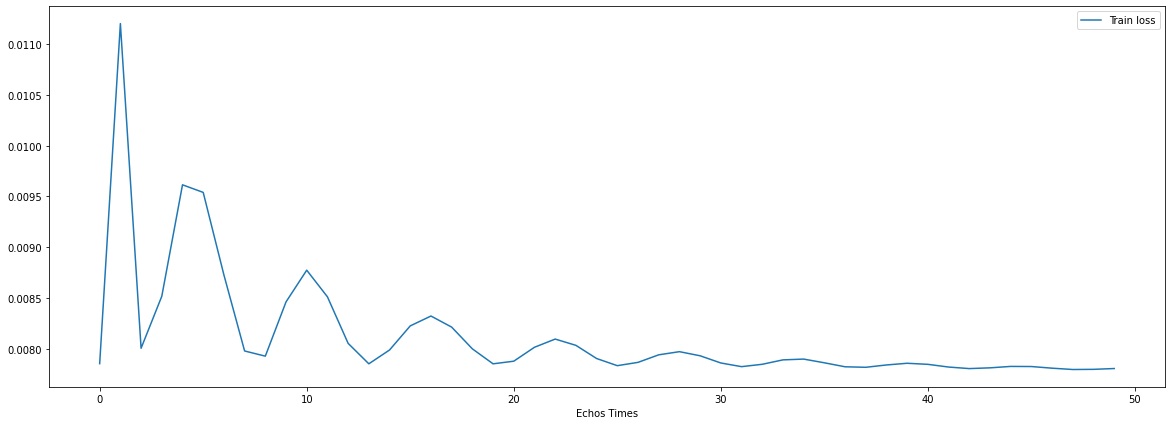

In [26]:
myplot.model_loss({"Train loss":train_hist_geo}, save_name=path+"geo_loss.png")

## Semigeo Features

In [28]:
model_semigeo = MLP_Regression(
  input_size=50,
  hidden_size=1000
)

In [29]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=semigeo_cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.03987644612789154 test loss: 0.03416585177183151
Epoch 10 train loss: 0.015826595947146416 test loss: 0.017771711573004723
Epoch 20 train loss: 0.013069787994027138 test loss: 0.014258201234042645
Epoch 30 train loss: 0.01222286932170391 test loss: 0.01315060630440712
Epoch 40 train loss: 0.011903861537575722 test loss: 0.013420903123915195
Epoch 49 train loss: 0.011672231368720531 test loss: 0.01333178672939539
Epoch 0 train loss: 0.012455694377422333 test loss: 0.006248512305319309
Epoch 10 train loss: 0.014177447184920311 test loss: 0.008005633018910885
Epoch 20 train loss: 0.012530301697552204 test loss: 0.00656420411542058
Epoch 30 train loss: 0.012133810669183731 test loss: 0.006165818776935339
Epoch 40 train loss: 0.012049933895468712 test loss: 0.0061114272102713585
Epoch 49 train loss: 0.011968876235187054 test loss: 0.00610077939927578
Epoch 0 train loss: 0.011739377863705158 test loss: 0.007848620414733887
Epoch 10 train loss: 0.013580667786300182 test 

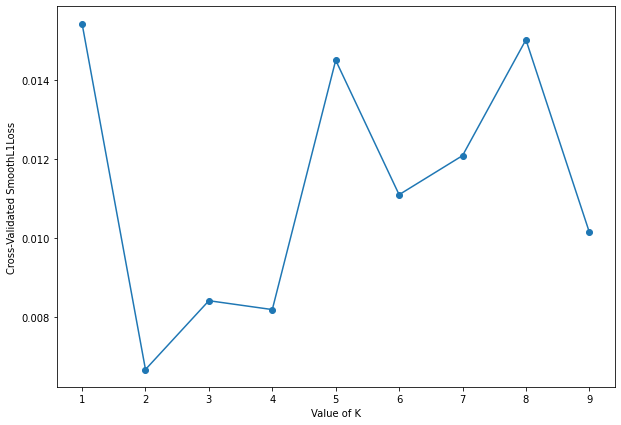

<Figure size 432x288 with 0 Axes>

In [30]:
myplot.k_fold_validation(n_groups, k_scores, save_name=path+"semigeo_k_fold.png")

### Train model

In [31]:
x_train, y_train = df_train[semigeo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [32]:
model_semigeo, train_hist_semigeo, _ = train_model(model_semigeo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            save_name=path+"semigeo_model.pth")

Epoch 0 train loss: 0.010201208293437958
Epoch 10 train loss: 0.011531013064086437
Epoch 20 train loss: 0.010310894809663296
Epoch 30 train loss: 0.010127680376172066
Epoch 40 train loss: 0.010101884603500366


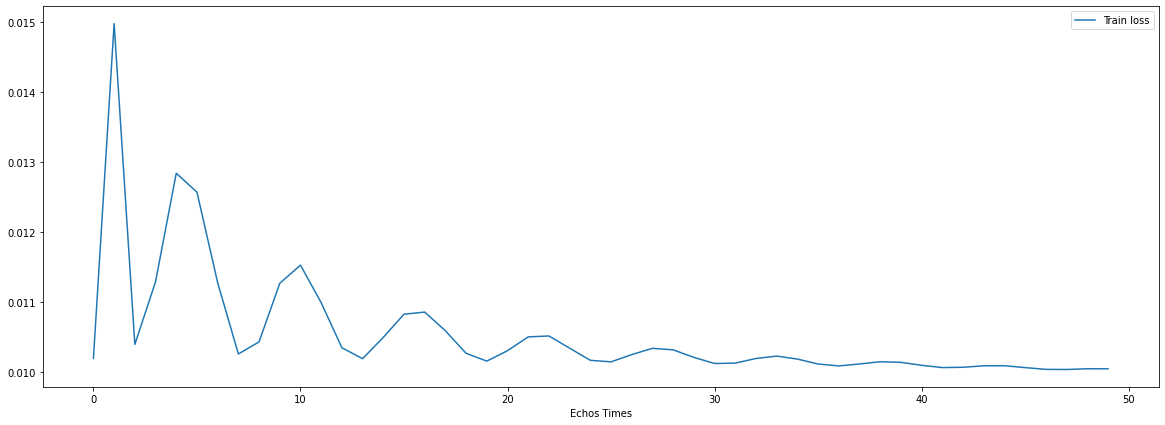

In [33]:
myplot.model_loss({"Train loss":train_hist_semigeo}, save_name=path+"semigeo_loss.png")